In [2]:
import json
import time
import math
from datetime import datetime
import os
from tqdm import trange, tqdm
import re
from copy import deepcopy


import csv
import unicodedata
import html
from io import StringIO
from html.parser import HTMLParser


import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from numpy import ndarray 
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2




from nptyping import NDArray, Int, Shape
from typing import Dict, List, Tuple, Union


from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import nltk
import ssl
from nltk.tokenize import word_tokenize
from collections import namedtuple


from piazza_api import Piazza
from piazza_api.network import Network

CRED_FILE = "creds3.json"



"""Custom Types"""
Answer = Dict[str,Dict[str,Union[str,int]]]
Post = Dict[str,Union[str, Union[str,int,List]]]

"""Macros"""
# who the answer is coming from
STUDENT, INSTRUCTOR, STUDENT_ENDORSED_ANSWERER = 0, 1, 2
EPSILON = 1e-05

# folder categories
GENERAL, LECTURES, ASSIGNMENTS, TESTS = 0, 1, 2, 3

# labels for sentiment
NEGATIVE, NEUTRAL, POSITIVE = 0, 1, 2

In [2]:
class MyHTMLParser(HTMLParser):
    """taken from: [1]"""
    
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    """strips html tags and substitutes html entities """
    #html = html.unescape(html)
    s =  MyHTMLParser()
    s.feed(html)
    return s.get_data()

In [6]:
def login() -> Tuple[dict, Network]:
    """logs user into Piazza"""

    email:str 
    password:str 
    courseid:str 

    with open(CRED_FILE) as f:
        creds = json.load(f)
        email, password, courseid = creds['email'], creds['password'], creds['courseid']


    #print(f"email: {email} \npassword: {password} \ncourseid: {courseid}")


    p: Piazza = Piazza()
    p.user_login(email, password)
    user_profile: dict = p.get_user_profile()
    course: Network = p.network(courseid)
    return user_profile, course

## Some Utilities

In [32]:
def get_post_creator(post: Post):
    for entry in post['change_log']:
        if entry['type'] == 'create':
            return entry['uid']


def get_post_created(post: Post):
    """get time post was created"""
    for entry in post['change_log']:
        if entry['type'] == 'create':
            return entry['when']


def get_posts_by_student(filename:str, student_id:str) -> List[Post]:
    student_posts = []
    with open(filename, 'r') as f:
        all_posts = json.load(f)
        for p in all_posts:
            if get_post_creator(p) == student_id:
                student_posts.append(p)
    return student_posts


def get_endorsed_students(course: Network) -> Tuple[Dict, Dict]:
    endorsed_users = {}
    non_endorsed_users = {}
    users = course.get_all_users()
    for u in users:
        if u['endorser']:
            endorsed_users[u['id']] = u['name']
        else:
            non_endorsed_users[u['id']] = u['name']


    return endorsed_users, non_endorsed_users


def is_private(post: Post, is_old=False) -> bool:
    """ Return true if post is private """
    if is_old: # use 'status' field of post to determine whether post is Private
        return True if post['status'] == 'private' else False

    #print(json.dumps(post['change_log'], indent=4, sort_keys=True))
    for entry in post['change_log']:
        if entry['type'] == 'create':
            return True if entry['v'] == 'private' else False



def get_answers(post:Post, endorsed_students: Dict) -> List[Dict[str, Answer]]:
    """ Get student and instructor answers """

    answers = {}
    answers['s_answer'] = {}
    answers['i_answer'] = {}

    for t in answers.keys():
        for ans in post['children']:
            if ans['type'] == t:      
                vals = answers[t]
                text = ans['history'][0]['content']
                #text = strip_tags(text)
                vals['text'] = text
                vals['poster'] = ans['history'][0]['uid']
                vals['date'] = ans['history'][0]['created']
                vals['num_helpful'] = len(ans['tag_endorse_arr'])
                # post creator is same student that liked response
                if get_post_creator(post) in ans['tag_endorse_arr']:
                    vals['is_helpful'] = True 
                else:
                    vals['is_helpful'] = False

                if ans['type'] == "s_answer":
                    
                    student_poster_id = ans['history'][0]['uid'] # id of the most recent student answer editor
                     # check if student is endorsed (actually not a valid way of checking)
                    vals['is_endorser'] = False
                    if student_poster_id in endorsed_students:
                        vals['is_endorser'] = True
                   
                break
    
    return answers

## Step 1: Convert raw Piazza data to csv file 

In [27]:
def export_posts_json(filename:str, course:Network) -> None:
    """Create json of all posts saved in current directory"""

    if os.path.exists(filename):
        print(f"{filename} already exists!")
        return 
    posts = course.iter_all_posts()
    all_posts = []
    #text = json.dumps(post['children'][1], sort_keys=True, indent=4)
    try:
        for p in tqdm(posts):
            time.sleep(1)
            all_posts.append(p)
    
    finally:
        print('------------------------------------')
        with open(filename, 'w') as f:
            json.dump(all_posts, f)

In [34]:

def json_to_csv(json_file_path: str, csv_filename: str, course: Network, is_overwrite_csv: bool=False, is_old=False) -> None:
    """ 
    :param json_file_path: Path to json file to convert to csv
    :param csv_filename: Name of csv file to save to cur directory
    :param course: Used to extract student profile to determine whether they are endorsed. **Actually not a valid way of checking**
    :param is_old: Toggle to true if course instance is 2019 or earlier. These posts use the 'status' field to determine whether
    a post is private
    """

    schema = ("post_id,is_private,question_title,question,folders,student_poster_name,date_question_posted," 
    "student_answer,student_answer_name,date_student_answer_posted,is_student_endorsed,is_student_helpful,"
    "instructor_answer,instructor_answer_name,date_instructor_answer_posted,is_instructor_helpful," 
    "is_followup\n")

    parser = MyHTMLParser()

    endorsed_students = get_endorsed_students(course)[0]

    with open(json_file_path, 'r') as json_file:
        with open(csv_filename, 'w') as csv_file:
            csv_file.write(schema)
            posts = json.load(json_file)
            num_posts = 0
            for post in tqdm(posts):   
                row = [] 
                if post['type'] == 'question':
                    question = post['history'][0] # newest update of question. Change index to -1 for oldest
                    question_title = question['subject']
                    question_content = question['content']
                    folders = ','.join(post['folders'])
                    date_created = get_post_created(post)
                    answers = get_answers(post, endorsed_students)
                    student_answer = answers['s_answer']
                    instructor_answer = answers['i_answer']
                 

                    row = [post['nr'], is_private(post, is_old), question_title, question_content, folders, get_post_creator(post), date_created]
                    s_row, i_row = [], []
                    if student_answer:
                        s_row = [student_answer['text'], student_answer['poster'], student_answer['date'], str(student_answer['is_endorser']), str(student_answer['is_helpful'])] 
                    else:
                        s_row = [None, None, None, None, None]

                    if instructor_answer:
                        i_row = [instructor_answer['text'], instructor_answer['poster'], instructor_answer['date'], str(instructor_answer['is_helpful'])] 
                    else:
                        i_row = [None, None, None, None]
                    
                    row = row + s_row + i_row

                    is_followup = 'False'

                    for c in post['children']:
                        if c['type'] == 'followup':
                            is_followup = 'True'
                    
                    row += [is_followup]

                    post_writer = csv.writer(csv_file)
                    post_writer.writerow(row)
                    
                    csv_file.write('\n')

                    num_posts += 1



In [35]:
user_profile,course = login()

#export_posts_json("csc108_fall2020.json", course)
json_to_csv("./csc108_fall2019.json", "csc108_fall2019.csv", course, is_old=True)


100%|██████████| 1949/1949 [00:00<00:00, 59136.67it/s]


## Manually viewing users and posts

In [33]:
user_profile,course = login()

# user = course.get_users(['krz7jwkviui2p3'])
post = course.get_post('19')

# p = course.get_feed()

text = json.dumps(post, sort_keys=True, indent=4)


# users = course.get_all_users()

# user

print(text)


{
    "anon_icons": true,
    "anon_map": {},
    "bookmarked": 3,
    "bucket_name": "Today",
    "bucket_order": 3,
    "change_log": [
        {
            "anon": "no",
            "data": "k0ade1ey8745yj",
            "type": "create",
            "uid": "k076noqwuui21v",
            "when": "2019-09-08T02:40:33Z"
        },
        {
            "anon": "no",
            "data": "k0adeol5ppg6gi",
            "to": "k0ade1ewlhs5yi",
            "type": "i_answer",
            "uid": "jlntsfq395i3j3",
            "when": "2019-09-08T02:41:03Z"
        },
        {
            "anon": "no",
            "data": "k0adf3s7ovi6mi",
            "type": "i_answer_update",
            "uid": "jlntsfq395i3j3",
            "when": "2019-09-08T02:41:23Z"
        },
        {
            "anon": "no",
            "data": "k0ago6o73cc66h",
            "type": "i_answer_update",
            "uid": "gzcyozk0MBl",
            "when": "2019-09-08T04:12:25Z"
        },
        {
            "anon":

How to handle posts with imgs? Do we want the img tags stripped? Think about how it will affect textual features
response length, sentiment, 

what elements do q&a contain?
latex, code snippets, imgs/screenshots, links, lists, annotations to prev posts (i.e. @356)

fields that can be added: num_answer_imgs, ...

can remove posts with imgs or include a special field called "num_imgs" so can distinguish b/w posts that have imgs

## Step 2: Feature Engineering - Transform csv into another csv with relevant features

In [52]:
FILEPATH_CSV = "./csc108_fall2021.csv"
AUGMENTED_FILEPATH_CSV = "./csc108_fall2021_sentiment_aug.csv"

In [53]:
data = pd.read_csv(FILEPATH_CSV, index_col=0)
data.tail()

len(data[data['is_private'] == True])
#len(data[data['is_private'] == False])

# data.keys()
# students = data[data[' is_student_endorsed'] == True]['student_answer_name']
# for s in students:
#     print(s)
data

,is_private,question_title,question,folders,student_poster_name,date_question_posted,student_answer,student_answer_name,date_student_answer_posted,is_student_endorsed,is_student_helpful,instructor_answer,instructor_answer_name,date_instructor_answer_posted,is_instructor_helpful,is_followup
post_id,,,,,,,,,,,,,,,,
3809,True,Summer Courses,<p>Which of the computer science courses are g...,utm/life/other,ksoq5pmzwq514u,2022-01-03T00:08:09Z,NaN,NaN,NaN,NaN,NaN,"<p>We will not know until March, when the summ...",gzcyozk0MBl,2022-01-03T00:51:25Z,False,False
3808,False,What should I do?,"<p>I failed csc108, so I&#39;m going to re-tak...",general,ksoq5tpdnh31kw,2022-01-02T21:20:18Z,<p>There&#39;s a chance that csc148 can be tak...,ksoq6exja9d3b9,2022-01-02T21:26:51Z,True,False,NaN,NaN,NaN,NaN,False
3807,False,What is the yotube account that made pcrs videos?,NaN,pcrs,ks9l55ygvlm30f,2022-01-02T16:05:36Z,https://youtube.com/channel/UCu8NnRGTGxHe96Le0...,kr2bzqy2dok7ou,2022-01-02T16:07:36Z,False,False,<p>There isn&#39;t a single account. Many of t...,gzcyozk0MBl,2022-01-02T16:08:36Z,False,False
3806,True,UTM Exam fail question,"<p>Hi, I&#39;m just confused about how the fai...",utm/life/other,ksoq5j54ygqp0,2022-01-02T01:42:10Z,NaN,NaN,NaN,NaN,NaN,<md>The grade you've received on Acorn is Fina...,jc6jo3gvkr8542,2022-01-02T01:43:55Z,False,True
3805,False,In-person Learning For Winter Term,"<md>Hello, will all courses (such as CSC148H5 ...",utm/life/other,ksoq6sru6w34ak,2022-01-01T05:52:58Z,<p>I believe so. </p>,ksoq6sajaqn48y,2022-01-01T05:54:54Z,True,False,<md>&gt; Does this mean I’ll be taking online ...,jc6jo3gvkr8542,2022-01-01T06:13:30Z,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,False,Spatial Skills: Pretest - Shapes difficult to ...,"<p>Hello,</p>\n<p></p>\n<p> As I was doing the...",spatial,ksoq5p0f71h12q,2021-08-24T04:42:07Z,<p>Its the dark mode making the shapes look od...,ksoq6px0rgz43d,2021-08-30T06:59:49Z,False,False,<p>Could you give us an example (screenshot) o...,gzcyozk0MBl,2021-08-24T04:45:41Z,False,True
15,False,Question I make based on Week 1 material,<p>Hello:</p>\n<p>There are question made by m...,general,keivl0bhdc52f5,2021-08-24T02:40:40Z,<p>Q1) 8**6//4&#43;6&#43;6*8</p>\n<p> = 2621...,ksoq5rauj41c2,2021-08-25T06:55:53Z,False,False,NaN,NaN,NaN,NaN,True
13,True,"Spatial skills: Orthographic Views 1, #3",<p>Hello:</p>\n<p>As I am doing the week 1 spa...,spatial,keivl0bhdc52f5,2021-08-23T20:08:34Z,<p>Just drop hints here: There will be some ed...,keivl0bhdc52f5,2021-08-23T21:17:37Z,True,False,<p>The key to this question is the dotted line...,k4ddfmb0gsb1h,2021-08-23T21:48:22Z,False,True


New schema: (post_id,student_poster_id,close_to_deadline, "is_followup"" 
    
    "answerer_id, date_answer_posted, reputation, is_helpful"
    
    )


    date_question_posted
    - close to deadline: yes/no

In [39]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jaipers5/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Utilities

In [47]:
def get_length(text:str) -> int:
    length = 0
    if isinstance(text, str):
        length = len(word_tokenize(text))
    else: # must be nan
        if not isnan(text):
            assert(1 == 0) # shouldn't get here
    
    return length


def is_references(text: str) -> bool:
    """ Check if answer contains a link to another post (i.e. @256) or a hyperlink
        :param text: question|answer with html stripping 
    """   
    return True if re.search(r'@+\d', text) or 'http' in text else False

def level_of_detail(text: str) -> bool:
    """ Detect imgs or code snippets
        :param text: raw question|answer without html stripping so can detect imgs/code-snippets
    """
    is_image = True if '<img' in text else False
    is_code_snippets = True if '<pre' in text else False

    return True if is_image or is_code_snippets else False


def answer_response_time(t1:str, t2:str) -> int:
    """:returns: Answer response time in mins, rounded up. Add option to use log scale?"""
    d1 = datetime.fromisoformat(t1[:-1])
    d2 = datetime.fromisoformat(t2[:-1])
    delta = d2-d1
    response_time = math.ceil(delta.total_seconds() // 60)
    if response_time == 0:
        response_time = EPSILON
    return response_time
    
def get_category(folder: str, folder_set: dict[str, int]) -> Union[str, bool]:
    """ For multi-categories just choose the 1st one.
        Varies b/w classes.

        :param folder: folder1,folder2, ...
        :param folder_set: set of all folders

        Precondition: folder should be part of folder_set

    """
    category = folder.split(',')[0]
    if category not in folder_set:
        return False

    return folder_set[category]


def get_sentiment(text: str, sentiment_model) -> int:
    senti = sentiment_model(text)[0]['label']
    if senti == 'LABEL_0':
        return NEGATIVE
    elif senti == 'LABEL_1':
        return NEUTRAL
    else:
        return POSITIVE
 

    

def add_answer(augmented_data:List[List], append_row:List, post_row:tuple, poster_dict: Dict[str, str], num_instances:int, answer_type:int,
              add_nlp_features=True, sentiment_model=None) -> int:
    """
    Append student or instructor answer fields to augmented_data.

    :param augmented_data: table to add append_row to
    :param append_row: partially filled row to be completed
    :param post_row: namedtuple containing information about the current Piazza post
    :param answer_type: INSTRUCTOR|STUDENT
    :returns: this is a description of what is returned
    :raises Nothing
    """
    poster =  'student' if answer_type == STUDENT  else 'instructor'
    fields = [f'{poster}_answer', f'{poster}_answer_name', f'is_{poster}_helpful', 'date_{poster}_answer_posted']
    increment_num_instances = False
    
    answer = getattr(post_row, f"{poster}_answer")
   
    if isinstance(answer, str): # if answer is nan, don't add an entry
        stripped_answer = strip_tags(answer)
        poster_id = getattr(post_row, f'{poster}_answer_name')
        if poster_id not in poster_dict:
            poster_dict[poster_id] = hash(poster_id)
            increment_num_instances = True

        is_helpful = 1 if getattr(post_row, f"is_{poster}_helpful") else 0

        
        #append_row.append(stripped_answer)
        append_row.append(poster_dict[poster_id])
        append_row.append(get_length(stripped_answer))
        append_row.append(is_references(stripped_answer))
        append_row.append(level_of_detail(answer))
        
        if add_nlp_features:
            append_row.append(get_sentiment(stripped_answer, sentiment_model))

        t1 = getattr(post_row, 'date_question_posted')
        t2 = getattr(post_row, f'date_{poster}_answer_posted')
        response_time = answer_response_time(t1, t2)


        append_row.append(response_time)
        
        append_row.append(answer_type)
        append_row.append(is_helpful)
        augmented_data.append(append_row)

    return increment_num_instances

    
#'general,lecture'.split(',')
    

In [13]:
#get_sentiment()
# a = "Cats"
# #get_sentiment(a, sentiment_pipeline)

# sentiment_pipeline(a)[0]['label']

# tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

# text = "Good night 😊"
# encoded_input = tokenizer(a, return_tensors='pt', truncation=True, max_length=512)
# output = model(**encoded_input)
# scores = output[0][0].detach().numpy()
#scores = softmax(scores)
#scores

In [41]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_pipeline = pipeline(model=MODEL, max_length=512, truncation=True)

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

### Add non-textual and textual features

Note that the NLP features take a while to compute

In [54]:
from math import isnan

def augment_data(data: DataFrame, folder_set: dict[str, int], add_nlp_features=True, sentiment_model=None, save_to_csv=True) -> DataFrame:

    augmented_data = []

    studentid_to_int = {}
    instructorid_to_int = {}
    num_users = 0
    #num_students, num_instructors = 0, 0

    num_iters = 0
    #num_iters_thresh = 10  # len(data.index)
    num_iters_thresh = len(data.index)

    #sentiment_pipeline = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment")

    for r in tqdm(data.itertuples(), total=num_iters_thresh, colour='green', desc="Augment csv data"):

        if num_iters > num_iters_thresh:
            break

       
        new_row = [r.Index] 
        new_row.append(r.is_private)
        category = get_category(r.folders, folder_set)

        # ignore posts that are part of an unknown category
        if not category: 
            continue

        new_row.append(category)
       
        if r.student_poster_name not in studentid_to_int:
            studentid_to_int[r.student_poster_name] = hash(r.student_poster_name) 
            num_users += 1
            
        new_row.append(studentid_to_int[r.student_poster_name])
        stripped_q = ""
        raw_question = ""
        question_sentiment = NEUTRAL
        if isinstance(r.question, str): 
            stripped_q = strip_tags(r.question)
            raw_question = r.question
            if add_nlp_features:
                question_sentiment = get_sentiment(stripped_q, sentiment_model) # strip down to 512 tokens

        #new_row.append(stripped_q)
        new_row.append(get_length(stripped_q))
        new_row.append(is_references(stripped_q))
        new_row.append(level_of_detail(raw_question))

        if add_nlp_features:
            new_row.append(question_sentiment)


    
        is_followup = 1 if r.is_followup else 0
        new_row.append(is_followup)

        # add separate rows for student and instructor answer
        num_users += add_answer(augmented_data, deepcopy(new_row), r, studentid_to_int, num_users, STUDENT, add_nlp_features, sentiment_model)
        num_users+= add_answer(augmented_data, deepcopy(new_row), r, instructorid_to_int, num_users, INSTRUCTOR, add_nlp_features, sentiment_model)
        num_iters += 1
    
    augmented_data = np.array(augmented_data)
    #print(augmented_data.shape)
    if add_nlp_features:
        augmented_df = pd.DataFrame(augmented_data, columns=['post_id', 'is_private', 'category', 'student_poster_id', 
        'question_length', 'is_question_references', 'question_lod', 'question_sentiment', 'is_followup', 
        'answerer_id', 'answer_length', 'is_answer_references', 'answer_lod', 'answer_sentiment', 'response_time',  'reputation', 'is_helpful'])
    else:
        augmented_df = pd.DataFrame(augmented_data, columns=['post_id', 'is_private', 'category', 'student_poster_id', 
        'question_length', 'is_question_references', 'question_lod', 'is_followup', 
        'answerer_id', 'answer_length', 'is_answer_references', 'answer_lod', 'response_time',  'reputation', 'is_helpful'])

    if save_to_csv:
        augmented_df.index.name = 'ID'
        augmented_df.to_csv(AUGMENTED_FILEPATH_CSV)


    return augmented_df


csc108_fall2021_categories = {'general': GENERAL, 'utm/life/other': GENERAL, 'lecture': LECTURES, 'lab': ASSIGNMENTS, 'tests/exam': TESTS}

csc108_fall2020_categories = {'general': GENERAL, 'administrative': GENERAL, 'post/uni-life': GENERAL, 'random': GENERAL, 'lecture': LECTURES, 
'minor_labs': ASSIGNMENTS, 'major_lab1': ASSIGNMENTS, 'major_lab2': ASSIGNMENTS, 'major_lab3': ASSIGNMENTS, 'major_lab4': ASSIGNMENTS, 
'major_lab5': ASSIGNMENTS, 'a1': ASSIGNMENTS, 'a2': ASSIGNMENTS, 'a3': ASSIGNMENTS, 'test1': TESTS, 'test2': TESTS, 'exam': TESTS}

csc108_fall2019_categories = {'general': GENERAL, 'misc': GENERAL, 'lecture': LECTURES, 'lab': ASSIGNMENTS, 'a0': ASSIGNMENTS, 
'a1': ASSIGNMENTS, 'a2': ASSIGNMENTS, 'a3': ASSIGNMENTS,  'midterm': TESTS, 'exam': TESTS}

#ignore_categories = {'spatial', 'pcrs', 'pcrs/spatial_skills'}


augmented_df = augment_data(data, csc108_fall2021_categories, add_nlp_features=True, sentiment_model=sentiment_pipeline)
#augmented_data[0].shape






Augment csv data: 100%|██████████| 3117/3117 [04:02<00:00, 12.83it/s]


### Split into train, val and test sets

In [19]:
csc108_fall2019 = pd.read_csv("csc108_fall2019_sentiment_aug.csv").set_index('ID')
csc108_fall2020 = pd.read_csv("csc108_fall2020_sentiment_aug.csv").set_index('ID')
csc108_fall2021 = pd.read_csv("csc108_fall2021_sentiment_aug.csv").set_index('ID')

len(csc108_fall2019)
#len(csc108_fall2020)
#len(csc108_fall2021)

1627

### Inspect dataset distributions

total number of samples is 7046
number of csc108_fall2019 posts is: 1627 0.23091115526539882%
number of csc108_fall2020 posts is: 3322 0.4714731762702242%
number of csc108_fall2021 posts is: 2097 0.2976156684643769%


([<matplotlib.patches.Wedge at 0x7f1b7eda2250>,
 [Text(0.8230365195247875, 0.7298019508938876, 'csc108_fall2019'),
  Text(-1.0759351619195325, 0.22883078321150202, 'csc108_fall2020'),
  Text(0.6532116586033543, -0.8850505799470757, 'csc108_fall2021')],
 [Text(0.44892901064988405, 0.3980737913966659, '23%'),
  Text(-0.5868737246833814, 0.12481679084263746, '47%'),
  Text(0.3562972683291023, -0.482754861789314, '30%')])

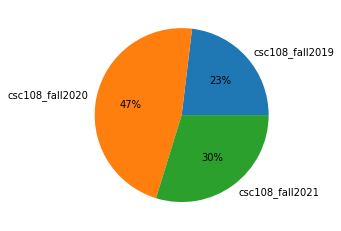

In [31]:
total_samples = len(csc108_fall2019) + len(csc108_fall2020) + len(csc108_fall2021)
print(f'total number of samples is {total_samples}')
print(f'number of csc108_fall2019 posts is: {len(csc108_fall2019)} {len(csc108_fall2019) / total_samples}%')
print(f'number of csc108_fall2020 posts is: {len(csc108_fall2020)} {len(csc108_fall2020) / total_samples}%')
print(f'number of csc108_fall2021 posts is: {len(csc108_fall2021)} {len(csc108_fall2021) / total_samples}%')
plt.pie([len(csc108_fall2019), len(csc108_fall2020), len(csc108_fall2021)], labels=['csc108_fall2019', 'csc108_fall2020', 'csc108_fall2021']
, autopct='%.0f%%')

number of unique posters is: 490


1986

In [77]:
# train = pd.concat([csc108_fall2019, csc108_fall2020], ignore_index=True)
# val_test = csc108_fall2021.to_csv('datasets/test.csv')
# train.index.name = 'ID'
# train.to_csv('datasets/train.csv')

csc108_fall2020.to_csv('datasets/train.csv')
csc108_fall2019.to_csv('datasets/val.csv')
csc108_fall2021.to_csv('datasets/test.csv')

### Methods and Sources of Noise in Data

<table>
  <tr>
    <th>Feature</th>
    <th>Extraction Method</th>
    <th>Noise</th>
    <th>in literature?</th>
    <th>justification of choice</th>
  </tr>
    <tr>
    <td>post id</td>
    <td>0.52</td>
    <td>0.13</td>
    <td>0.13</td>
    <td>0.13</td>
  </tr>
    <tr>
    <td>is_private</td>
    <td>0.52</td>
    <td>0.13</td>
    <td>0.13</td>
    <td>0.13</td>
  </tr>
  <tr>
    <td>category</td>
    <td>0.52</td>
    <td>0.13</td>
    <td>0.13</td>
    <td>0.13</td>
  </tr>
  <tr>
    <td>is_question_references</td>
    <td>0.95</td>
    <td>0.78</td>
    <td>0.13</td>
    <td>0.13</td>
  
 
</table>






#### Question length

##### Method
- strip html tags and take token length
##### Noise

- imgs not factored into question length. imgs make question short when it is in reality longer
- question length = 0,1
  - question included in subject. Concat subject+question?
  - question inc. img/screenshot and actual question is in subject
- can include code snippets which makes question really long


#### Is question references
- checks if question contains 

## References

[1] https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python